# Python for Finance im Mastermodul "Termingeschäfte und Finanzderivate" - Teil 2
___
Dieses Jupyter Notebook basiert auf den Beispielen aus "Python for Finance - 2nd Edition" von Yves Hilpisch: http://shop.oreilly.com/product/0636920117728.do
<br>
Sämtliche Beispiele sind zu finden unter: https://github.com/yhilpisch/py4fi2nd

### Urheberrechtsinformationen:

Python for Finance, 2nd Edition, by Dr. Yves J. Hilpisch (O'Reilly). Copyright 2019 Yves Hilpisch, 978-1-492-02433-0
<br>
___
Version 1.0.0
<br>
Weitere Projekte sind zu finden unter: https://github.com/trh0ly

## Grundlegende Einstellungen:

Zunächst müssen die notwendigen Pakete (auch Module) importiert werden, damit auf diese zugegriffen werden kann. 

In [1]:
import numpy as np # Programmbibliothek die eine einfache Handhabung von Vektoren, Matrizen oder generell großen mehrdimensionalen Arrays ermöglicht
import datetime # Das datetime-Modul stellt Klassen bereit, mit denen Datums- und Uhrzeitangaben auf einfache und komplexe Weise bearbeitet werden können
import operator # Programmbibliothek, welche die Ausgaben übersichtlicher gestaltet
import matplotlib.pyplot as plt # Programmbibliothek die es erlaubt mathematische Darstellungen aller Art anzufertigen
from valuation_mcs_european import valuation_mcs_european
from plot_option_stats import plot_option_stats
from geometric_brownian_motion import geometric_brownian_motion
import datetime as dt
from get_year_deltas import get_year_deltas
from constant_short_rate import constant_short_rate
from market_environment import market_environment

Anschließend werden Einstellungen definiert, die die Formatierung der Ausgaben betreffen.
Hierfür wird das Modul `operator` genutzt.
Außerdem wird die Breite des im Folgenden genutzten DataFrames erhöht und die Größe der Grafiken modifiziert, welche später angezeigt werden sollen.

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

##########################################################################
#-------------------------------------------------------------------------

SCREEN_WIDTH = 125 # Breite Outputbox
SIZE = [15,10] # Größe Grafiken / Textgröße

#-------------------------------------------------------------------------
##########################################################################

centered = operator.methodcaller('center', SCREEN_WIDTH)
plt.rcParams["figure.figsize"] = SIZE[0],SIZE[1] 

Es werden der Barwert, das Delta (Wertänderung der Option in Relation zur Kursbewegung des Underlyings) und das Vega (Volatilität) einer europäischen Call-Option geschätzt. Zur Berechnung des Calls werden drei Dinge benötigt:
- Das Underlying, welches über die Funktion market_environment simuliert wird
- Die Auszahlungs- bzw. Bewertungsfunktion (max(Wert Underlying - Basispreis, 0))
- Die Bewertung der Option bis zum Fälligkeitszeitpunkt

Das Underlying nimmt dabei Werte von 34-46 EUR an und der Basispreis (Strike) beträgt 40€. Der Bewertungszeitraum ist vom 1.1.2020-31.12.2020.

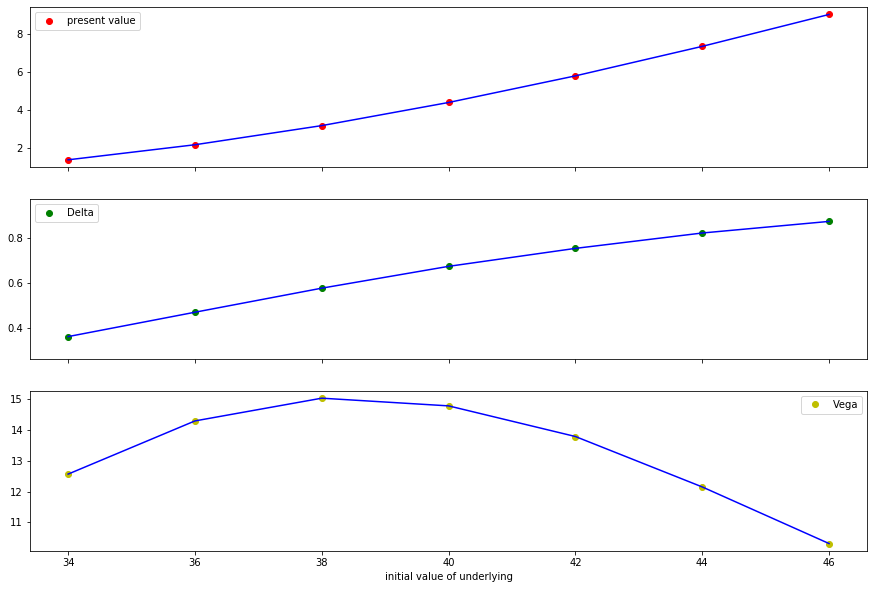

In [4]:
#-------------------------------------------------------------------------
# Hinzufügen einer Marktumgebung für das Underlying

me_gbm = market_environment('me_gbm', dt.datetime(2020, 1, 1))
me_gbm.add_constant('initial_value', 36.) 
me_gbm.add_constant('volatility', 0.2)
me_gbm.add_constant('final_date', dt.datetime(2020, 12, 31))
me_gbm.add_constant('currency', 'EUR')
me_gbm.add_constant('frequency', 'M')
me_gbm.add_constant('paths', 10000)

csr = constant_short_rate('csr', 0.06)
me_gbm.add_curve('discount_curve', csr)

#-------------------------------------------------------------------------
# Simulation des Underlyings
gbm = geometric_brownian_motion('gbm', me_gbm)

#-------------------------------------------------------------------------
# Hinzufügen einer Marktumgebung für die Option
me_call = market_environment('me_call', me_gbm.pricing_date)
me_call.add_constant('strike', 40.)
me_call.add_constant('maturity', dt.datetime(2020, 12, 31))
me_call.add_constant('currency', ' EUR')

#-------------------------------------------------------------------------
# Anwendung der Bewertungsfunktion
payoff_func = 'np.maximum(maturity_value - strike, 0)'
eur_call = valuation_mcs_european('eur_call', underlying=gbm, mar_env=me_call, payoff_func=payoff_func)

#-------------------------------------------------------------------------
# Vorbereitungen und Aufruf der Funktion zur Visualisierung der berechneten Werte
s_list = np.arange(34., 46.1, 2.)
p_list = []; d_list = []; v_list = []

for s in s_list:
    eur_call.update(initial_value=s)
    p_list.append(eur_call.present_value(fixed_seed=True))
    d_list.append(eur_call.delta())
    v_list.append(eur_call.vega())

plot_option_stats(s_list, p_list, d_list, v_list)

Die Bewertungsmethode kann nicht nur für Plain-Vanilla-Optionen verwendet werden, sondern auch für komplexere Auszahlungsfunktionen (payoff_func). In diesem Beispiel wird ein Mischung aus regulärer Auszahlungsstruktur und der Auszahlung von Asiatischen Optionen (gehört zur Gruppe der exotische Optionen) verwendet. In diesem Beispiel ist die Auszahlungsfunktion max(0,33 * (Fälligskeitswert + Maximum des Underlyings) - Basispreis, 0).

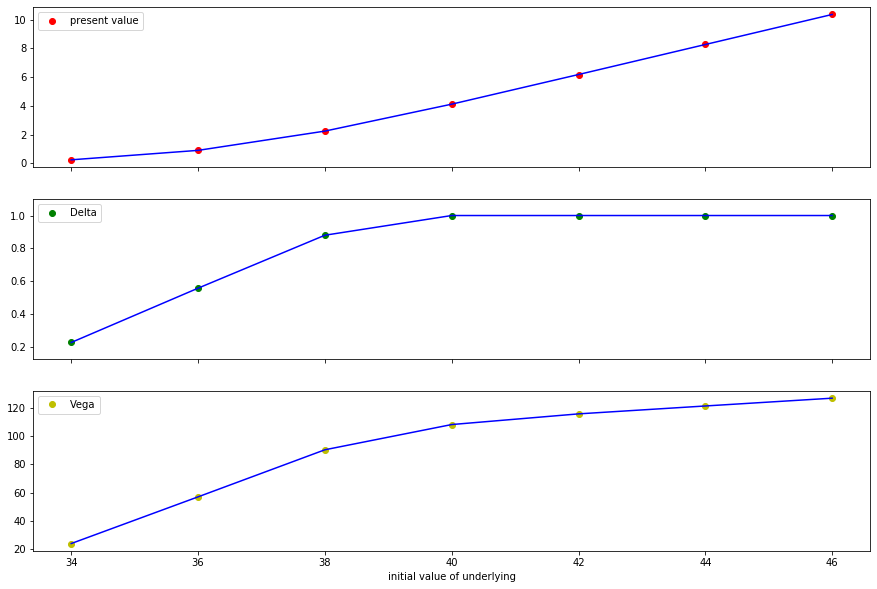

In [5]:
#-------------------------------------------------------------------------
# Anwendung der Bewertungsfunktion
payoff_func = 'np.maximum(0.33 * '
payoff_func += '(maturity_value + max_value) - 40, 0)'
eur_as_call = valuation_mcs_european('eur_as_call', underlying=gbm, mar_env=me_call, payoff_func=payoff_func)

#-------------------------------------------------------------------------
# Vorbereitungen und Aufruf der Funktion zur Visualisierung der berechneten Werte
s_list = np.arange(34., 46.1, 2.)
p_list = []; d_list = []; v_list = []

for s in s_list:
    eur_as_call.update(s)
    p_list.append(eur_as_call.present_value(fixed_seed=True))
    d_list.append(eur_as_call.delta())
    v_list.append(eur_as_call.vega())
    
plot_option_stats(s_list, p_list, d_list, v_list)